# Analysis B: Gaze Distribution

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

import pickle

def save_obj(obj, name, path = 'obj/'):
    with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name, path = 'obj/'):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)


gazedf = pd.read_csv('obj/gaze_df.csv', index_col =0) #load gaze distribution
participants = load_obj('participants')


# Gaze distributions
gazedf contains all the gaze distribution for all the participants for all trials in all experimental conditions (time frame starting from ttp<9s to ttp = 0s.

Surface meanings:
* gaze_fw = front window
* gaze_ic = instrument cluster
* gaze_lm = left mirror
* gaze_lmopt = left mirror optimistic surface (meaning the larger drawn square)
* gaze_tm = gaze top mirror
* gaze_tmopt = top mirror optimist
* none = not on any surface

The figure below shows how the surfaces were defined in the software.

<img src="img/areas.png" alt="Drawing" style="width: 900px;"/>

From gazedf, we can select gaze distributions as follows. For example, here we select the distributions belonging to the first participant from the participant list, in run uctun, where the vehicle approached from the direction FR. These are three trials, which are denoted by an identical number (nr column).



In [2]:
#select a participant, and run and show dataframe
p = participants[0] # first participant from list
r = 'uctun' #run, (experimental condition)
direction = 'FR' # alternatives: FRs, FL, BL, BR


selected = gazedf[(gazedf['participant']==p) &(gazedf['run'] == r) &(gazedf['direction']=='FR')]
selected

,nr,participant,run,direction,surface,count
0,29,XSMS,uctun,FR,total,1516
0,29,XSMS,uctun,FR,gaze_fw,1381
0,29,XSMS,uctun,FR,gaze_ic,17
0,29,XSMS,uctun,FR,gaze_lm,36
0,29,XSMS,uctun,FR,gaze_lmopt,83
0,29,XSMS,uctun,FR,gaze_tm,0
0,29,XSMS,uctun,FR,gaze_tmopt,0
0,29,XSMS,uctun,FR,none,36
0,40,XSMS,uctun,FR,total,1935
0,40,XSMS,uctun,FR,gaze_fw,1659


We can calculate the front gaze ratio, plot it in a boxplot and do the Wilcoxon signed rank test. 

The front gaze ratio is defined as the ratio of the amount of gaze point in the front window versus the amount of gaze point in the mirror plus the wind shield. A higher front gaze ratio indicates that the user allocated more attention towards the front. See the paper for more info.

A note to reviewers of the thesis: The following code blocks were written by Matti, who helped me with this code when the deadline of the paper submission got close. 

In [4]:
# Note: This block of code was written by Matti Krueger.

# load gaze data with duration information
gaze2df = pd.read_csv('obj/gazedfWithDurations.csv', index_col =0)
#participants = load_obj('participants')

# translations and cosmetics
# COLORS = {}
# blocks
LABELS = {}
LABELS['noucfog'] = 'MC-HU'
LABELS['noucrain'] = 'MU-HC'
LABELS['nouctun'] = 'MU-HU'
LABELS['ucrain'] = 'MU-HC-uc'
LABELS['uctun'] = 'MU-HU-uc'
LABELS['B'] = 'Back'
LABELS['F'] = 'Front'

def gaze_ratio(df, 
               frontsurfaces=['gaze_fw'],
               backsurfaces=['gaze_lmopt', 
                             'gaze_tmopt'], 
               rationames=['ratiofront', 
                           'ratioback']):
    """Create new dataframe that provides for each trial the 
    percentage of gaze points in one set of areas of of interest compared
    to the sum of gaze points for the primary set of AOIs and another
    set of AOIs. 
    
    With the default parameters the ratio of front/(front + rearview)
    is calculated. 
    
    Returns: 
        New dataframe with columns as specified by 'rationames'
    """
    
    # define column labels
    columns=['participant', 'nr', 'run', 'direction', 'Approach'] + rationames
    ratiodf = pd.DataFrame(columns=columns)
    
    # for each participant
    participants = df.participant.unique()
    for participant in participants:
        # for each trial
        trials = df.query('participant == "{}"'.format(participant)).nr.unique()
        for trial in trials:
            
            condition = 'participant == "{}" and nr == {}'.format(participant, trial)
            runs = df.query(condition).run.unique()
            
            # because some "nr"s are assigned more than once, 
            # "run" is needed for further separation 
            for run in runs:
                condition = 'participant == "{}" and nr == {} and run == "{}"'.format(participant, trial, run)
                front = 0.0
                for surface in frontsurfaces:
                    surfcond = '{} and surface == "{}"'.format(condition, surface)
                    front += df.query(surfcond)['count'][0]
                back = 0.0
                for surface in backsurfaces:
                    surfcond = '{} and surface == "{}"'.format(condition, surface)
                    back += df.query(surfcond)['count'][0]
                #print('participant: {} trial: {}, front {}'.format(participant, trial, front))#/(front+back))
                ratiodf = ratiodf.append({
                    'participant':participant,
                    'nr':trial,
                    'run':LABELS[run], 
                    'direction':df.query(condition).direction.unique()[0],
                    'Approach':LABELS[df.query(condition).direction.unique()[0][0]],
                    rationames[0]:front/(front+back),
                    rationames[1]:back/(front+back)
                }, ignore_index=True)
            
    ratiodf['run'] = ratiodf.run.astype('category')
    ratiodf['direction'] = ratiodf.direction.astype('category')
    return ratiodf

Calculate the gaze ratio:

In [ ]:
# get ratio of front/(front + mirror)
ratiodf_f_b = gaze_ratio(gaze2df)

# remove nan entries
ratiodf_f_b = ratiodf_f_b.dropna()
#ratiodf

Next, we generate a plot with the gaze ratio calculated for all participants. We used the letters a, b, c and d instead of the experimental condition abbreviations for shorter code.

In [6]:
condition = 'Approach == "Back" and (run == "MU-HU-uc" or run == "MU-HU" or run == "MU-HC-uc" or run == "MU-HC")'
selected = ratiodf_f_b.query(condition)

a = selected[selected.run == 'MU-HC']
b = selected[selected.run == 'MU-HC-uc']

c = selected[selected.run=='MU-HU']
d = selected[selected.run=='MU-HU-uc']

dfab = {'participant':[], 'scorea':[], 'scoreb':[]} # dataframe with condition a and b
for p in a['participant'].unique():
    pmeana = a.loc[a['participant']==p,'ratiofront'].mean()
    pmeanb = b.loc[b['participant']==p,'ratiofront'].mean()
    dfab['participant'].append(p)
    dfab['scorea'].append(pmeana)
    dfab['scoreb'].append(pmeanb)
dfab = pd.DataFrame(dfab)

dfcd = {'participant':[], 'scorec':[], 'scored':[]}
for p in c['participant'].unique():
    pmeanc = c.loc[c['participant']==p,'ratiofront'].mean()
    pmeand = d.loc[d['participant']==p,'ratiofront'].mean()
    dfcd['participant'].append(p)
    dfcd['scorec'].append(pmeanc)
    dfcd['scored'].append(pmeand)
dfcd = pd.DataFrame(dfcd)

In [7]:
A = dfab[['participant', 'scorea']]
A = pd.concat([A, pd.DataFrame({'run':['MU-HC']*len(dfab)})],axis = 1)


B = dfab[['participant', 'scoreb']]
B = pd.concat([B, pd.DataFrame({'run':['MU-HC-uc']*len(dfab)})],axis = 1)

C = dfcd[['participant', 'scorec']]
C = pd.concat([C, pd.DataFrame({'run':['MU-HU']*len(dfcd)})],axis = 1)

D = dfcd[['participant', 'scored']]
D = pd.concat([D, pd.DataFrame({'run':['MU-HU-uc']*len(dfcd)})],axis = 1)

A.columns = ['participant', 'score', 'run']
B.columns = ['participant', 'score', 'run']
C.columns = ['participant', 'score', 'run']
D.columns = ['participant', 'score', 'run']
merged  =pd.concat([A,B,C,D])

An overview of the gaze ratio per condition, for all participants:

In [8]:
merged

,participant,score,run
0,TWOU,0.955911,MU-HC
1,MVNT,0.781360,MU-HC
2,ZPQX,0.813249,MU-HC
3,PVNT,0.815274,MU-HC
4,OYWO,0.920972,MU-HC
5,PVOU,0.839490,MU-HC
6,WVPV,0.680045,MU-HC
7,TTVN,0.819404,MU-HC
8,QPMS,0.805773,MU-HC
9,XSMS,0.832669,MU-HC


Plotting this: 

<IPython.core.display.Javascript object>


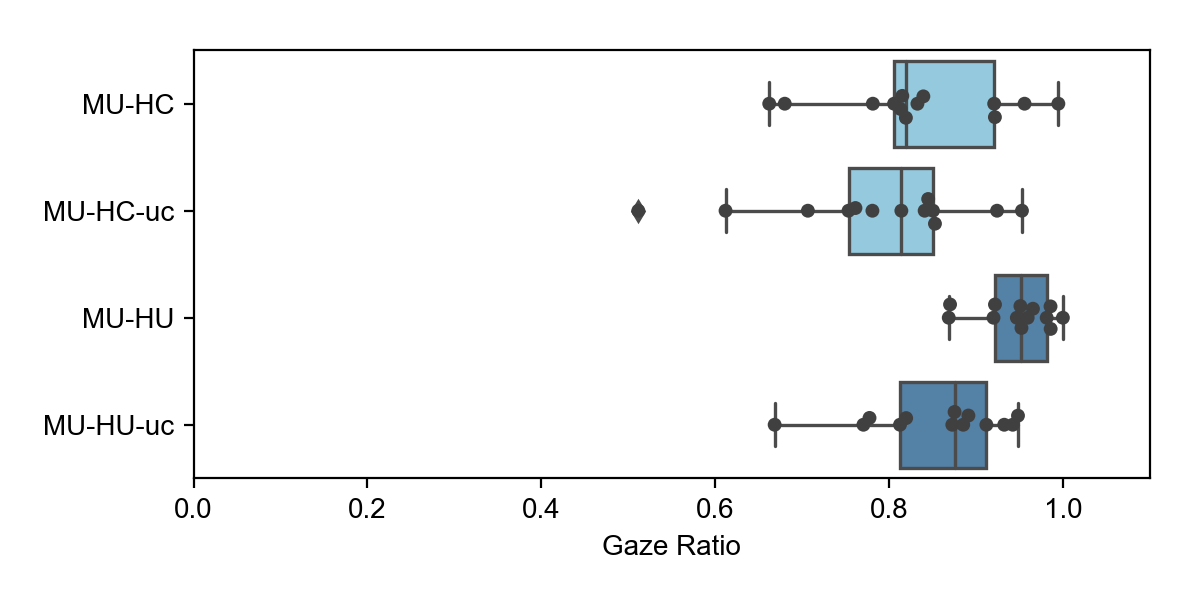

In [9]:
fig, ax = plt.subplots(figsize = (6,3))
sns.set_context('paper', font_scale=1.5)

clrs = ['skyblue', 'skyblue', 'steelblue', 'steelblue']

sns.set_style('whitegrid')
sns.boxplot(y='run', x='score', data=merged, ax=ax, palette = clrs) #color = 'skyblue')

sns.swarmplot(y='run', x='score', data=merged, color=".25", ax = ax)
ax.set_xlim(0,1.1)

plt.ylabel('')
plt.xlabel('Gaze Ratio')
plt.tight_layout()
# plt.savefig('gazeratio.eps')

### Statistical comparison

How to interpret the T metric can be found in appendices of statistics textbooks, for example in Table B-3 of Nonparametric Statistics: A Step-by-Step Approach, 2nd Edition by Dale I. Foreman and Gregory W. Corder (https://www.oreilly.com/library/view/nonparametric-statistics-a/9781118840429/bapp02.xhtml). The Wilcoxon package of the scipy stats package calculates this value. We only reported the p-values to avoid confusion between the t-tests used elsewere. 

In [11]:
from scipy import stats
wil_ab = stats.wilcoxon(dfab['scorea'], dfab['scoreb'])
wil_cd = stats.wilcoxon(dfcd['scorec'], dfcd['scored'])
# stats.ttest_rel(df['scorea'], df['scoreb'])

print(f'One sided Wilcoxon T test: \n MU-HC vs. MU-HC-uc: T = {wil_ab[0]}, p = {wil_ab[1]/2} \n MU-HU vs. MU-HU-uc: T = {wil_cd[0]}, p = {wil_cd[1]/2}')

One sided Wilcoxon T test: 
 MU-HC vs. MU-HC-uc: T = 24.0, p = 0.06647864648116782 
 MU-HU vs. MU-HU-uc: T = 0.0, p = 0.0007368904219375711
